In [105]:
!pip install xarray
!pip install rioxarray

In [106]:
import rasterio, fiona
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas
from rasterio.mask import mask
import pandas as pd
import numpy as np
import json
import matplotlib.patches as mpatches
import matplotlib.colors
from scipy.signal import medfilt2d
from rasterstats import zonal_stats
import rioxarray
import xarray
import glob

In [107]:
list_nc = glob.glob(r"C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution 2.5PM\*.nc")
# print(list_nc)
ind = list_nc[0].index("2000")
print("the index of year is {}".format(ind),list_nc[1][89:93])

#Convert all downloaded .nc files to .tif files for analysis
path = r"C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution Raster"
for i in list_nc:
    print(i)
    rds = rioxarray.open_rasterio(i,)
    rds.rio.write_crs("epsg:4326", inplace=True)
    rds.rio.to_raster(path+"/"+i[89:93]+".tif")

the index of year is 89 2001
C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution 2.5PM\V4NA03_PM25_NA_200001_200012-RH35.nc
C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution 2.5PM\V4NA03_PM25_NA_200101_200112-RH35.nc
C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution 2.5PM\V4NA03_PM25_NA_200201_200212-RH35.nc
C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution 2.5PM\V4NA03_PM25_NA_200301_200312-RH35.nc
C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution 2.5PM\V4NA03_PM25_NA_200401_200412-RH35.nc
C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution 2.5PM\V4NA03_PM25_NA_200501_200512-RH35.nc
C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution 2.5PM\V4NA03_PM25_NA_200601_200612-RH35.nc
C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution 2.5PM\V4NA03_PM25_NA_200701_200712-RH35.nc
C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution 2.5PM\V4NA03_PM

,Shape_Leng,Shape_Area,ADM0_ES,ADM0_PCODE,ADM0_REF,ADM0ALT1ES,ADM0ALT2ES,date,validOn,validTo,geometry
0,354.605876,173.513956,México,MX,Mexico,None,None,2018-02-02,2020-06-18,None,"MULTIPOLYGON (((-92.77034 15.15128, -92.77107 ..."


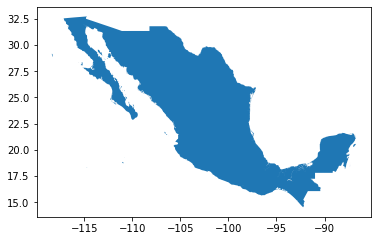

In [16]:
#Getting shape file for mexico districts (municipalities)
path_shape = r"C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Git_Pollution\Pollution_Sp21\Data\boundary_shp"
mex_district = geopandas.read_file(path_shape+"/mex_admbnda_adm2_govmex_20200618.shp") 
mexico = geopandas.read_file(path_shape+"/mex_admbnda_adm0_govmex_20200618.shp")
mexico.plot()
mexico

In [22]:
list_tif = glob.glob(r"C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution Raster\*.tif")
index_ = list_tif[0].index("2000")
print(index_)
 
# open tif files with rasterio and save them as pm2004, pm2009 and pm2014    
for i in list_tif:
    if int(i[75:79]) in [2004, 2009, 2014]:
        print(i)
        globals()['pm_%s' % i[75:79]] = rasterio.open(i)     


75
C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution Raster\2004.tif
C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution Raster\2009.tif
C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution Raster\2014.tif


ValueError: invalid literal for int() with base 10: 'pm20'

In [23]:
#check co-ordinates
pm2004.crs == mex_district.crs

True

In [24]:
#Function to send geometry from shapefile to raster
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

path_clip = r"C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Pollution Raster"


# Function to clip_raster
def clip_raster(raster, vector, filename):
    img_out, img_transform = mask(raster,getFeatures(vector), crop=True)  
    out_meta = raster.meta.copy()
    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = img_transform
    with rasterio.open(path_clip+'/'+filename+".tif", "w", **out_meta) as dest:
        dest.write(img_out)
    
    return rasterio.open(path_clip+'/'+filename+".tif")
    

In [25]:
#Clipping Rasters to mexico
pm2004_c = clip_raster(pm2004, mexico, "pm2004_clip")
pm2009_c = clip_raster(pm2009, mexico, "pm2009_clip")
pm2014_c = clip_raster(pm2014, mexico, "pm2014_clip")

In [26]:
#Function to retrive mean values at district level
def get_zonal_stats(vector, raster, stats):
    result = zonal_stats(vector, raster, stats = "mean", geojson_out = True)
    geostats = geopandas.GeoDataFrame.from_features(result)
    return geostats

In [98]:
#Doing zonal stats for all three years and appending them into one - to create panel data

pollution_mean_2004 = get_zonal_stats(mex_district, path_clip+'/'+"pm2004_clip.tif", "mean")
pollution_mean_2009 = get_zonal_stats(mex_district, path_clip+'/'+"pm2009_clip.tif", "mean")
pollution_mean_2014 = get_zonal_stats(mex_district, path_clip+'/'+"pm2014_clip.tif", "mean")

pm_df04 = pollution_mean_2004[["ADM0_ES","ADM1_ES","ADM2_ES","mean"]]
pm_df04 = pm_df04.rename(columns={"mean": "pollution","ADM2_ES": "Municipality", "ADM1_ES":"State"})
pm_df04["year"] = 2004

pm_df09 = pollution_mean_2009[["ADM0_ES","ADM1_ES","ADM2_ES","mean"]]
pm_df09 = pm_df09.rename(columns={"mean": "pollution","ADM2_ES": "Municipality", "ADM1_ES":"State"})
pm_df09["year"] = 2009

pm_df14 = pollution_mean_2014[["ADM0_ES","ADM1_ES","ADM2_ES","mean"]]
pm_df14 = pm_df14.rename(columns={"mean": "pollution","ADM2_ES": "Municipality", "ADM1_ES":"State"})
pm_df14["year"] = 2014


frames_1 = [pm_df04, pm_df09, pm_df14]

pm_df = pd.concat(frames_1)




<AxesSubplot:>

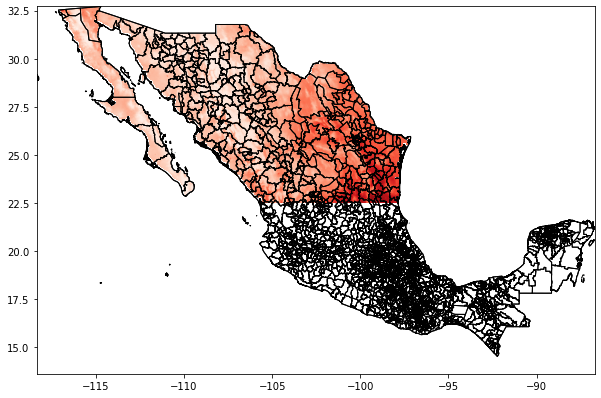

In [83]:
fig, ax = plt.subplots(figsize=(10, 10))
show(pm2004_c, ax=ax,cmap="Reds")
mexico.plot(ax=ax, facecolor='none', edgecolor='black')
mex_district.plot(ax=ax, facecolor='none',edgecolor = 'black')

### Doing the same steps for night lights data

In [108]:
night_light = r'C:\Users\gv4\Box\2. Research\Air Pollution and Prediction\Nightlights\sdei-global-annual-gwr-pm2-5-modis-misr-seawifs-aod-2012-geotiff'

In [33]:
nl2004 = rasterio.open(night_light+"/Harmonized_DN_NTL_2004_calDMSP.tif")
nl2009 = rasterio.open(night_light+"/Harmonized_DN_NTL_2009_calDMSP.tif")
nl2014 = rasterio.open(night_light+"/Harmonized_DN_NTL_2014_simVIIRS.tif")

In [85]:
nl2004_c = clip_raster(nl2004, mexico, "nl2004_clip")
nl2009_c = clip_raster(nl2009, mexico, "nl2009_clip")
nl2014_c = clip_raster(nl2014, mexico, "nl2014_clip")

<AxesSubplot:>

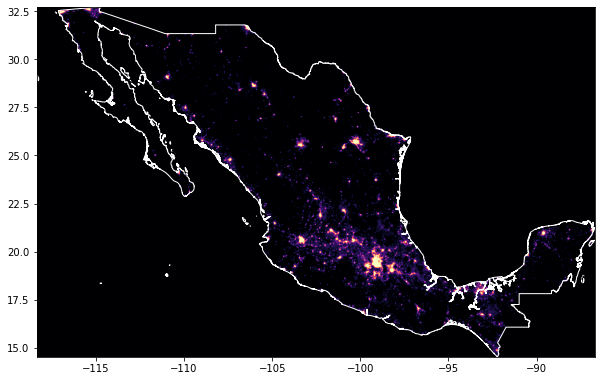

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))
show(nl2009_c, ax=ax, cmap = "magma")
mexico.plot(ax=ax, facecolor='none', edgecolor='white')
# mex_district.plot(ax=ax, facecolor='none',edgecolor = 'black')

In [86]:
nightlight_mean_2004 = get_zonal_stats(mex_district, path_clip+'/'+"nl2004_clip.tif", "mean")
nightlight_mean_2009 = get_zonal_stats(mex_district, path_clip+'/'+"nl2009_clip.tif", "mean")
nightlight_mean_2014 = get_zonal_stats(mex_district, path_clip+'/'+"nl2014_clip.tif", "mean")

In [88]:
nightlight_mean_2004.columns
nl_df04 = nightlight_mean_2004[["ADM0_ES","ADM1_ES","ADM2_ES","mean"]]
nl_df04 = nl_df04.rename(columns={"mean": "nightlight","ADM2_ES": "Municipality", "ADM1_ES":"State"})
nl_df04["year"] = 2004

nl_df09 = nightlight_mean_2009[["ADM0_ES","ADM1_ES","ADM2_ES","mean"]]
nl_df09 = nl_df09.rename(columns={"mean": "nightlight","ADM2_ES": "Municipality", "ADM1_ES":"State"})
nl_df09["year"] = 2009

nl_df14 = nightlight_mean_2014[["ADM0_ES","ADM1_ES","ADM2_ES","mean"]]
nl_df14 = nl_df14.rename(columns={"mean": "nightlight","ADM2_ES": "Municipality", "ADM1_ES":"State"})
nl_df14["year"] = 2014

frames = [nl_df04, nl_df09, nl_df14]

nl_df = pd.concat(frames)


In [111]:
print("Missing values in pollution:{}".format(pm_df04['pollution'].isnull().sum()))
print("Missing values in nightlights:{}".format(nl_df04['nightlight'].isnull().sum()))
pm_df04.shape

Missing values in pollution:2057
Missing values in nightlights:0


(2456, 5)

## Currently I do not have the full airpollution dataset for Mexico, hence 3/4 of districts have NaN values ie 2057 out of 2456 districts. I need to replace the current air-pollution data with global data

In [103]:
df_final = pd.merge(pm_df, nl_df)


## Final Panel Data for three years 2004, 2009 and 2014. Need to add average values from Chirps and Chirts and then merge with economic outcome data

In [104]:
df_final

,ADM0_ES,State,Municipality,pollution,year,nightlight
0,México,Yucatán,Abalá,NaN,2004,3.330579
1,México,Coahuila de Zaragoza,Abasolo,8.152508,2004,0.417266
2,México,Guanajuato,Abasolo,NaN,2004,10.231565
3,México,Nuevo León,Abasolo,9.480000,2004,15.482759
4,México,Tamaulipas,Abasolo,11.299029,2004,0.410827
...,...,...,...,...,...,...
7363,México,Puebla,Zoquiapan,NaN,2014,7.523810
7364,México,Puebla,Zoquitlán,NaN,2014,6.309309
7365,México,Veracruz de Ignacio de la Llave,Zozocolco de Hidalgo,NaN,2014,7.325581
7366,México,México,Zumpahuacán,NaN,2014,11.577236
